In [1]:
import numpy as np
import pandas as pd

import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/miniconda3/envs/py39/lib/python3.9/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [ ]:
# Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(n_samples=1000, noise=0.3)
X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset='boston')

pool2 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool2 = pool1.fit(X_train, y_train)

p2g2 = pool2graph.pool2graph(X_train, y_train, pool2, k_init=10)
p2g2.fit(max_epochs=10)

p2g2.G.nodes(data=True)[-1]

In [333]:
def get_discrepancy_intervals_from_x(G, x, k=10):

    # Get all discrepancy intervals from the graph
    intervals = discrepancies_intervals.get_discrepancies_intervals(G)

    # Compute distances between x and every discrepancy interval
    dists = []
    for di in intervals:
        dists.append( di.get_min_dist_to_point(x) )

    # Retrieve borders of the k closest intervals - and the points from the train at the origin of the intervals
    borders, train = {}, {}
    i = 0
    for di in np.array(intervals)[np.argsort(dists)][:k]:
        df = di.border_features
        df = pd.DataFrame(df)
        borders[i] = df 

        df = [p2g.G.nodes(data=True)[di.X_train_nodes[i]]['features'] for i in [0,1]]
        df = pd.DataFrame(df)
        train[i] = df
        i += 1

    return borders, train

In [335]:
discr = [p2g2.pool.predict([x]) for i,x in X_test.iterrows()]

tmp = [d.loc[0] for d in discr]
np.array(range(len(tmp)))[np.array(tmp)==1]

array([  0,   8,  15,  23,  26,  30,  33,  44,  55,  58,  71,  73,  74,
        82,  94,  96, 101, 104, 113, 122, 123, 131, 135, 142, 145, 152,
       154, 157, 160, 163])

In [595]:
def normalize(x):
    return ((x-X_test.min())/(X_test.max()-X_test.min()))

x = X_test.loc[0]
k = 10

borders, train = get_discrepancy_intervals_from_x(p2g2.G, x, k=k)
#fi = borders[1]
fi = {}
for interval in range(k):
    fi[interval] = borders[interval].iloc[1,:]
    fi[-(k+1)] = borders[interval].iloc[0,:]
fi = pd.DataFrame(fi).T

tmp = normalize(fi.max())

<Figure size 640x480 with 0 Axes>

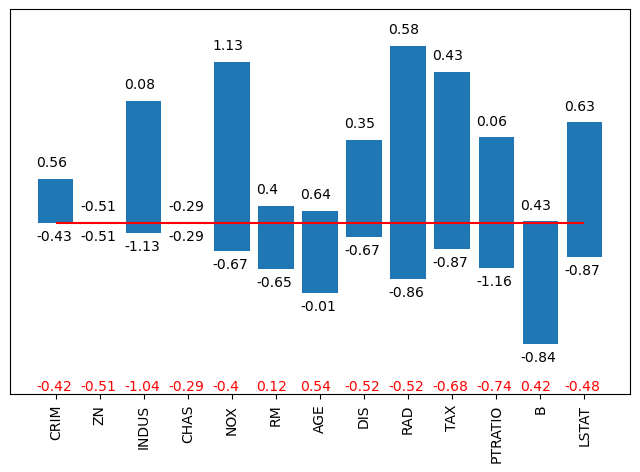

In [596]:
import matplotlib as mpl

mpl.style.use('default')
plt.viridis()

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(x=range(len(x)), height=normalize(fi.max())-normalize(fi.min()), bottom=normalize(fi.min())-normalize(x))

plt.hlines(0, 0, 12, color='r')

for i in range(len(x)):
    y1 = normalize(fi.max()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y1+0.03, str(fi.max().round(2).iloc[i]))

for i in range(len(x)):
    y2 = normalize(fi.min()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y2-0.04, str(fi.min().round(2).iloc[i]))

for i in range(len(x)):
    y2 = -0.35
    ax.text(i-0.45, y2-0.04, str(x.round(2).iloc[i]), c='r')

gar = ax.set_ylim((-0.4,0.5))
gar = ax.set(yticklabels=[])
gar = ax.tick_params(left=False)
gar = plt.xticks(np.arange(len(x)), list(x.index), rotation=90)

plt.savefig('top10_interval.pdf')

<Figure size 640x480 with 0 Axes>

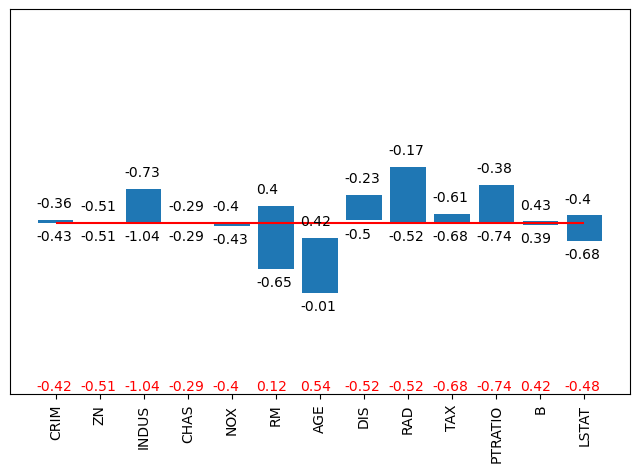

In [594]:
import matplotlib as mpl

fi = borders[1]

mpl.style.use('default')
plt.viridis()

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(x=range(len(x)), height=normalize(fi.max())-normalize(fi.min()), bottom=normalize(fi.min())-normalize(x))

plt.hlines(0, 0, 12, color='r')

for i in range(len(x)):
    y1 = normalize(fi.max()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y1+0.03, str(fi.max().round(2).iloc[i]))

for i in range(len(x)):
    y2 = normalize(fi.min()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y2-0.04, str(fi.min().round(2).iloc[i]))

for i in range(len(x)):
    y2 = -0.35
    ax.text(i-0.45, y2-0.04, str(x.round(2).iloc[i]), c='r')

gar = ax.set_ylim((-0.4,0.5))
gar = ax.set(yticklabels=[])
gar = ax.tick_params(left=False)
gar = plt.xticks(np.arange(len(x)), list(x.index), rotation=90)

plt.savefig('top1_interval.pdf')

In [ ]:
dict_vars = {'CRIM':'per capita crime rate by town',
'ZN':'proportion of residential land zoned for lots over 25,000 sq.ft.',
'INDUS':'proportion of non-retail business acres per town.',
'CHAS' : 'Charles River dummy variable (1 if tract bounds river; 0 otherwise)',
'NOX' : 'nitric oxides concentration (parts per 10 million)',
'RM' : 'average number of rooms per dwelling',
'AGE' : 'proportion of owner-occupied units built prior to 1940',
'DIS' : 'weighted distances to five Boston employment centres',
'RAD' : 'index of accessibility to radial highways',
'TAX' : 'full-value property-tax rate per $10,000',
'PTRATIO' : 'pupil-teacher ratio by town',
'B' : '1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
'LSTAT' : '\% lower status of the population',
'MEDV' : 'Median value of owner-occupied homes in $1000\'s'}

In [481]:
a = normalize(fi.max())
b = normalize(x)
c = normalize(fi.min())
e = normalize(X_test.min())
f = normalize(X_test.max())

pd.concat((e,c,b,a,f),axis=1)

,0,1,2,3,4
CRIM,0.0,0.038245,0.063113,0.106531,1.0
ZN,0.0,0.000000,0.000000,0.000000,1.0
INDUS,0.0,0.646628,0.646628,0.646628,1.0
CHAS,0.0,0.000000,0.000000,0.000000,1.0
NOX,0.0,0.292276,0.463466,0.670146,1.0
RM,0.0,0.426220,0.662084,0.566034,1.0
AGE,0.0,0.363539,0.654584,0.931770,1.0
DIS,0.0,0.119084,0.142938,0.307005,1.0
RAD,0.0,1.000000,1.000000,1.000000,1.0
TAX,0.0,0.913958,0.913958,0.913958,1.0


In [482]:
a = fi.max()
b = x
c = fi.min()
e = X_test.min()
f = X_test.max()

pd.concat((e,c,b,a,f),axis=1)

,0,1,15,2,3
CRIM,-0.435643,-0.069409,0.168731,0.584503,9.140393
ZN,-0.510601,-0.510601,-0.510601,-0.510601,3.847250
INDUS,-1.552450,0.982782,0.982782,0.982782,2.368249
CHAS,-0.288214,-0.288214,-0.288214,-0.288214,3.469649
NOX,-1.408384,-0.216987,0.480831,1.323320,2.667896
RM,-3.843953,-0.785548,0.906927,0.217709,3.331696
AGE,-2.247924,-1.026151,-0.048015,0.883542,1.112849
DIS,-1.211068,-0.680478,-0.574192,0.156829,3.244545
RAD,-0.980168,1.677124,1.677124,1.677124,1.677124
TAX,-1.331541,1.546715,1.546715,1.546715,1.817680


Coordinate of the point x:
         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
33  0.042574 -0.510601  0.982782 -0.288214  1.808388 -1.341369  0.976698   

         DIS       RAD       TAX   PTRATIO         B     LSTAT  
33 -0.774669  1.677124  1.546715  0.864421  0.252724 -0.321823  
         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
321  0.118514 -0.510601  0.982782 -0.288214  1.808388 -0.299205  0.442844   
61   0.201463 -0.510601  0.982782 -0.288214  0.625501 -1.886074  1.112849   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  
321 -0.585306  1.677124  1.546715  0.864421  0.365192  0.024042  
61  -1.134763  1.677124  1.546715  0.864421  0.193156 -1.288292  
         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
61   0.201463 -0.510601  0.982782 -0.288214  0.625501 -1.886074  1.112849   
321  0.118514 -0.510601  0.982782 -0.288214  1.808388 -0.299205  0.442844   

          DIS       RAD    

<AxesSubplot:>

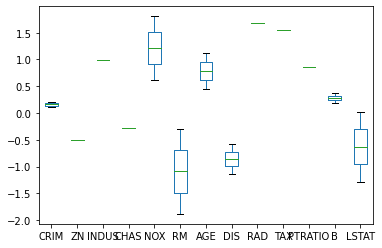

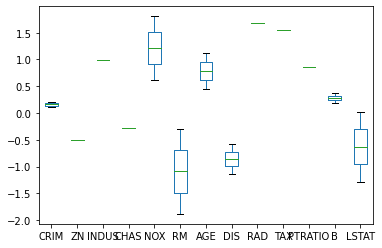

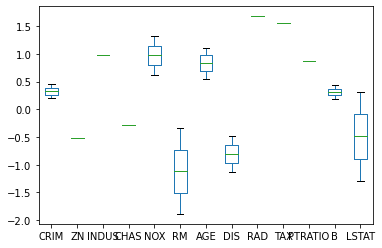

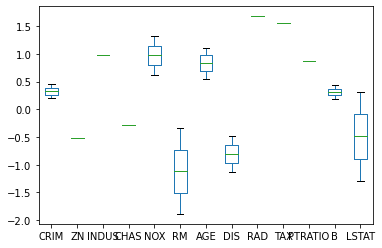

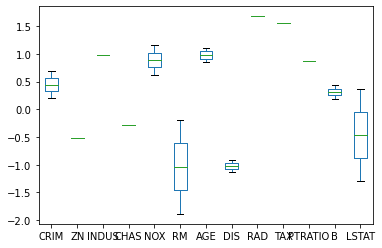

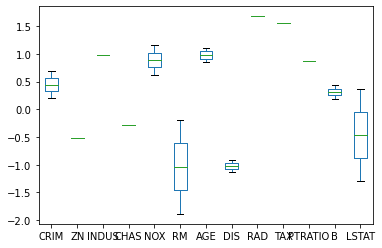

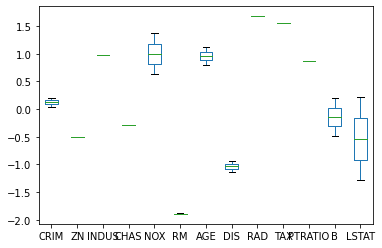

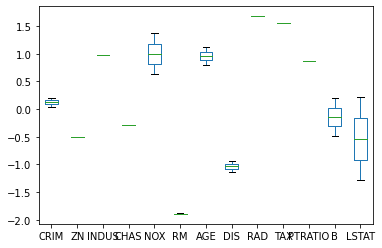

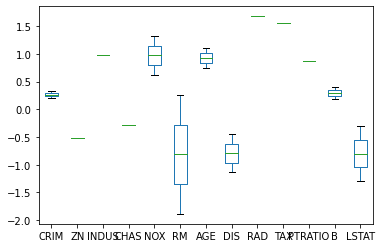

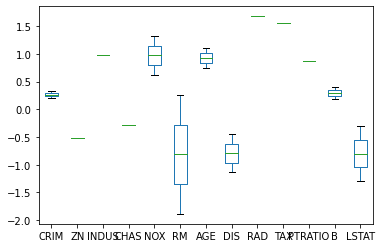

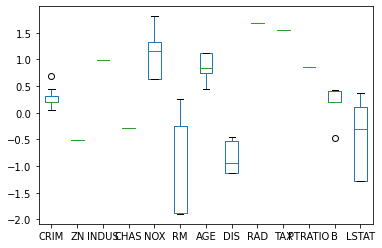

In [334]:
print(f'Coordinate of the point x:\n {x}')

for i in range(k):
    print(borders[i])
    borders[i].plot.box()

fi = {}
for interval in range(k):
    fi[interval] = borders[interval].iloc[1,:]
    fi[-(k+1)] = borders[interval].iloc[0,:]
fi = pd.DataFrame(fi).T

fi.plot.box()

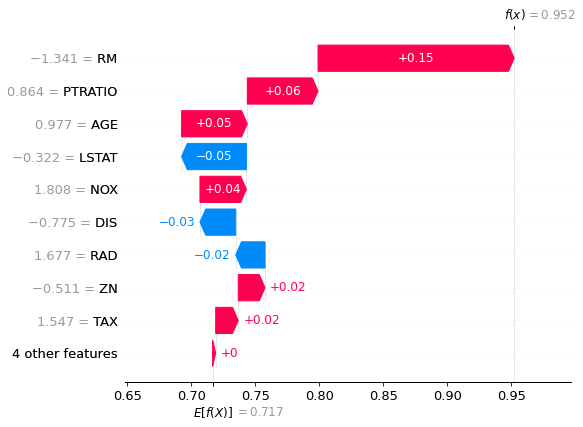

In [134]:
import shap

clf = lambda x: p2g2.pool.models['autosklearn#1'].predict_proba(x)[:,1]
mean = X_train.mean().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(clf, mean)
shap_values = explainer(x)
shap.plots.waterfall(shap_values[0])

In [182]:
import shap

shp = {}
for i in range(1,7):

    clf = lambda x: p2g2.pool.models[f'autosklearn#{i}'].predict_proba(x)[:,1]
    med = X_train.mean().values.reshape((1,X_train.shape[1]))
    explainer = shap.Explainer(clf, med)
    shap_values = explainer(x)
    #shap.plots.waterfall(shap_values[0])

    shp[f'autosklearn#{i}'] = pd.Series(shap_values.values[0], index=x.columns)